# Choosing a location for an oil well

Suppose you work for the oil production company "GlavRosGosNeft". You need to decide where to drill a new well.

You are provided with oil samples from three regions: each has 10,000 oil fields, where the quality of oil and the volume of reserves were measured. Build a machine learning model to help determine the region where production will bring the most profit. Analyze possible profit and risks using the *Bootstrap* technique.

Steps for choosing a location:

- In the selected region, fields are searched, and feature values are determined for each;
- A model is built and the volume of reserves is estimated;
- Fields with the highest estimated values are selected. The number of fields depends on the company's budget and the cost of developing one well;
- Profit is equal to the total profit from the selected fields.

**Project goal: to select the potentially most profitable place for drilling oil wells using machine learning methods.**

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import phik

from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler
)

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import root_mean_squared_error

RANDOM_STATE = 44
TEST_SIZE = 0.25

from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

## Loading and preparing data

In [3]:
df_reg_1 = pd.read_csv('geo_data_0.csv')
df_reg_2 = pd.read_csv('geo_data_1.csv')
df_reg_3 = pd.read_csv('geo_data_2.csv')

In [4]:
df_reg_1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
df_reg_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
df_reg_2.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [7]:
df_reg_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
df_reg_3.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [9]:
df_reg_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


**The data from three regions includes 10,000 entries in each table, no missing values, data format is correct: target and regular features are quantitative and represented as float64.**

**Let's perform a simple correlation analysis, plot a heatmap of phi_k correlation coefficients and scatter plots for all regions.**

**For the first region:**

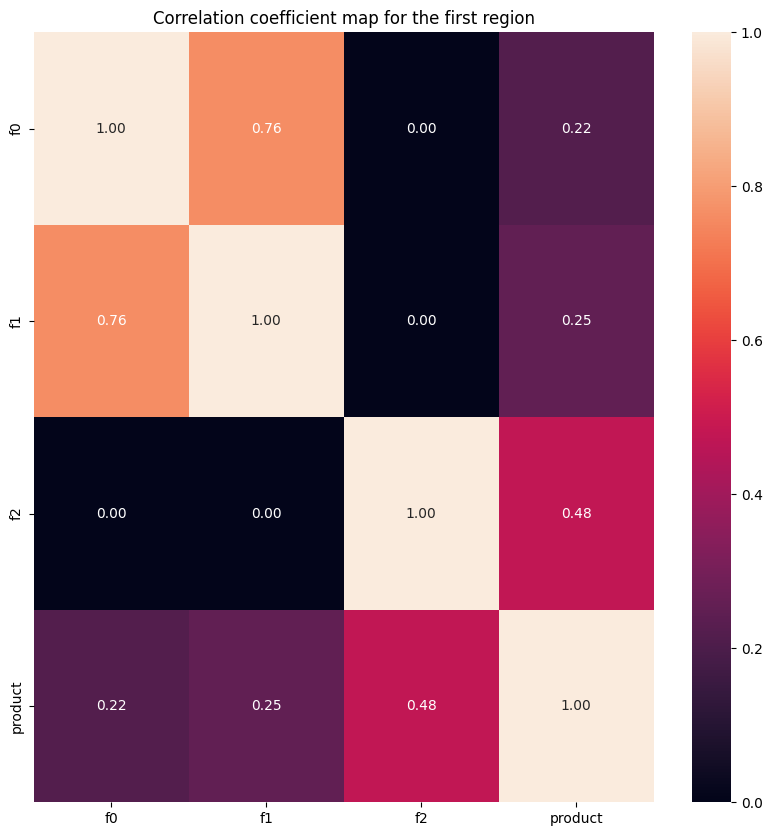

In [10]:
interval_cols = ['f0', 'f1', 'f2', 'product']
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Correlation coefficient map for the first region')
sns.heatmap(df_reg_1.drop('id', axis=1).phik_matrix(interval_cols=interval_cols),
            annot=True, 
            fmt='.2f',
            ax=ax) 
print()

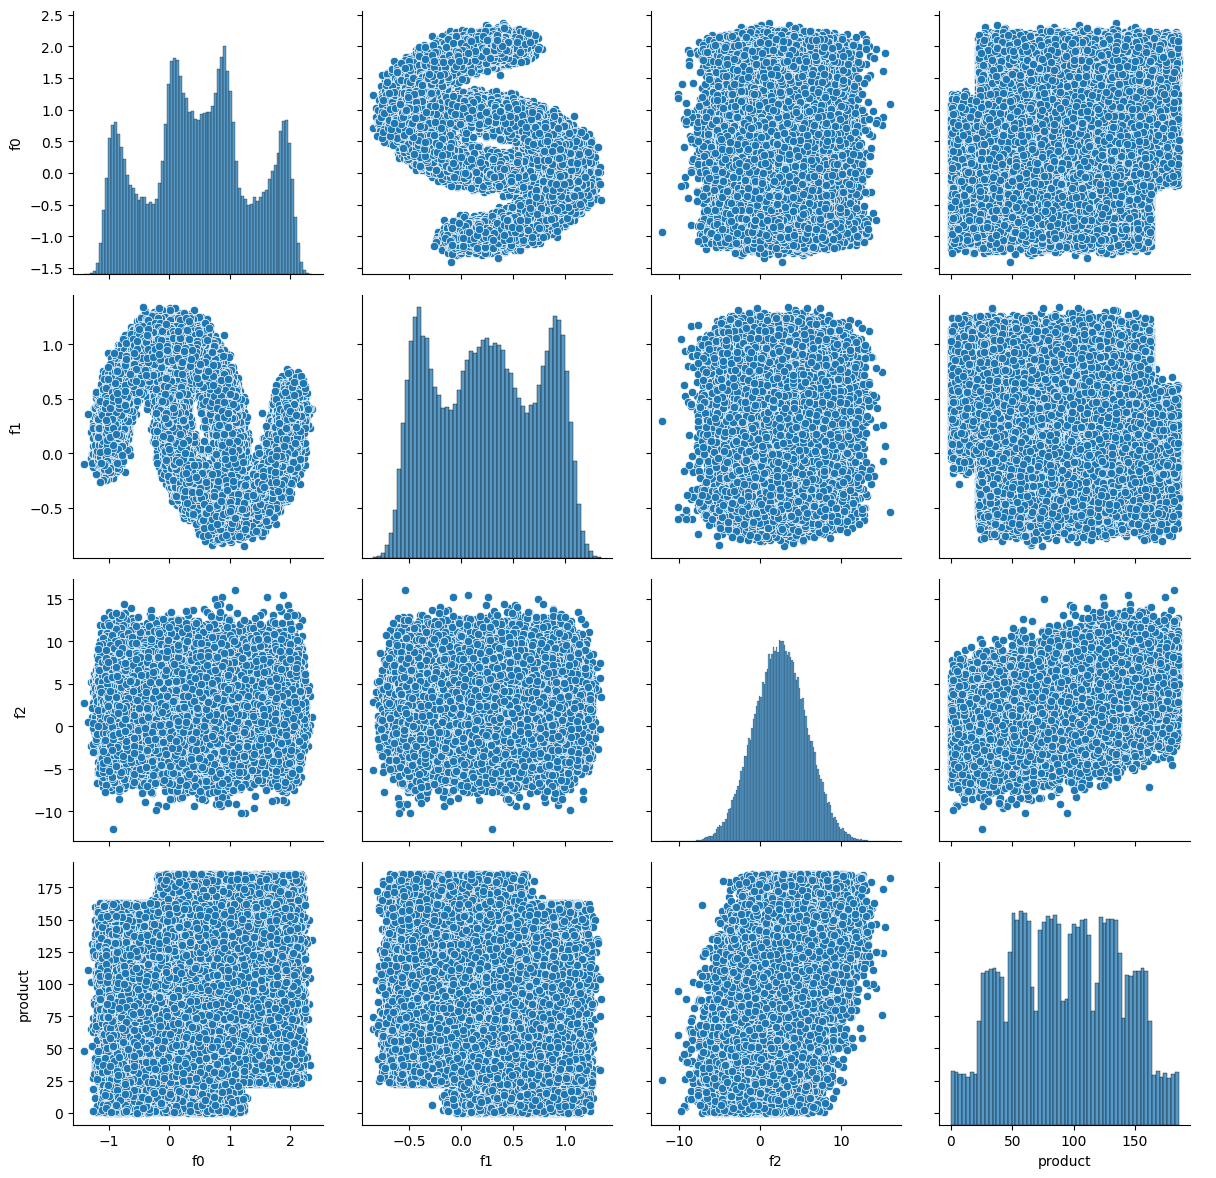

In [11]:
pair = sns.PairGrid(df_reg_1.drop('id', axis=1), height=3)
pair.map_diag(sns.histplot, hue=None)
pair.map_offdiag(sns.scatterplot)
pair.add_legend();

**In the first region, features f0 and f1 have a fairly strong correlation: phi_k = 0.76, and on the scatter plot, their distribution relative to each other resembles a polynomial function (or looks like a yin-yang symbol). For model training, we will keep only feature f1, as it correlates more strongly with the target.**

**For the second region:**

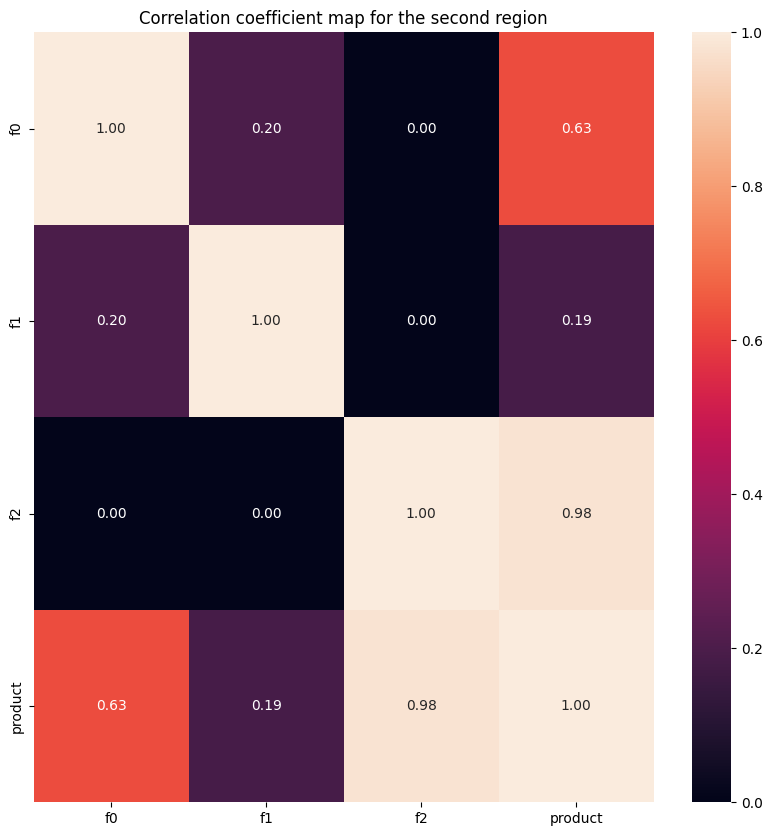

In [12]:
interval_cols = ['f0', 'f1', 'f2', 'product']
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Correlation coefficient map for the second region')
sns.heatmap(df_reg_2.drop('id', axis=1).phik_matrix(interval_cols=interval_cols),
            annot=True, 
            fmt='.2f',
            ax=ax) 
print()

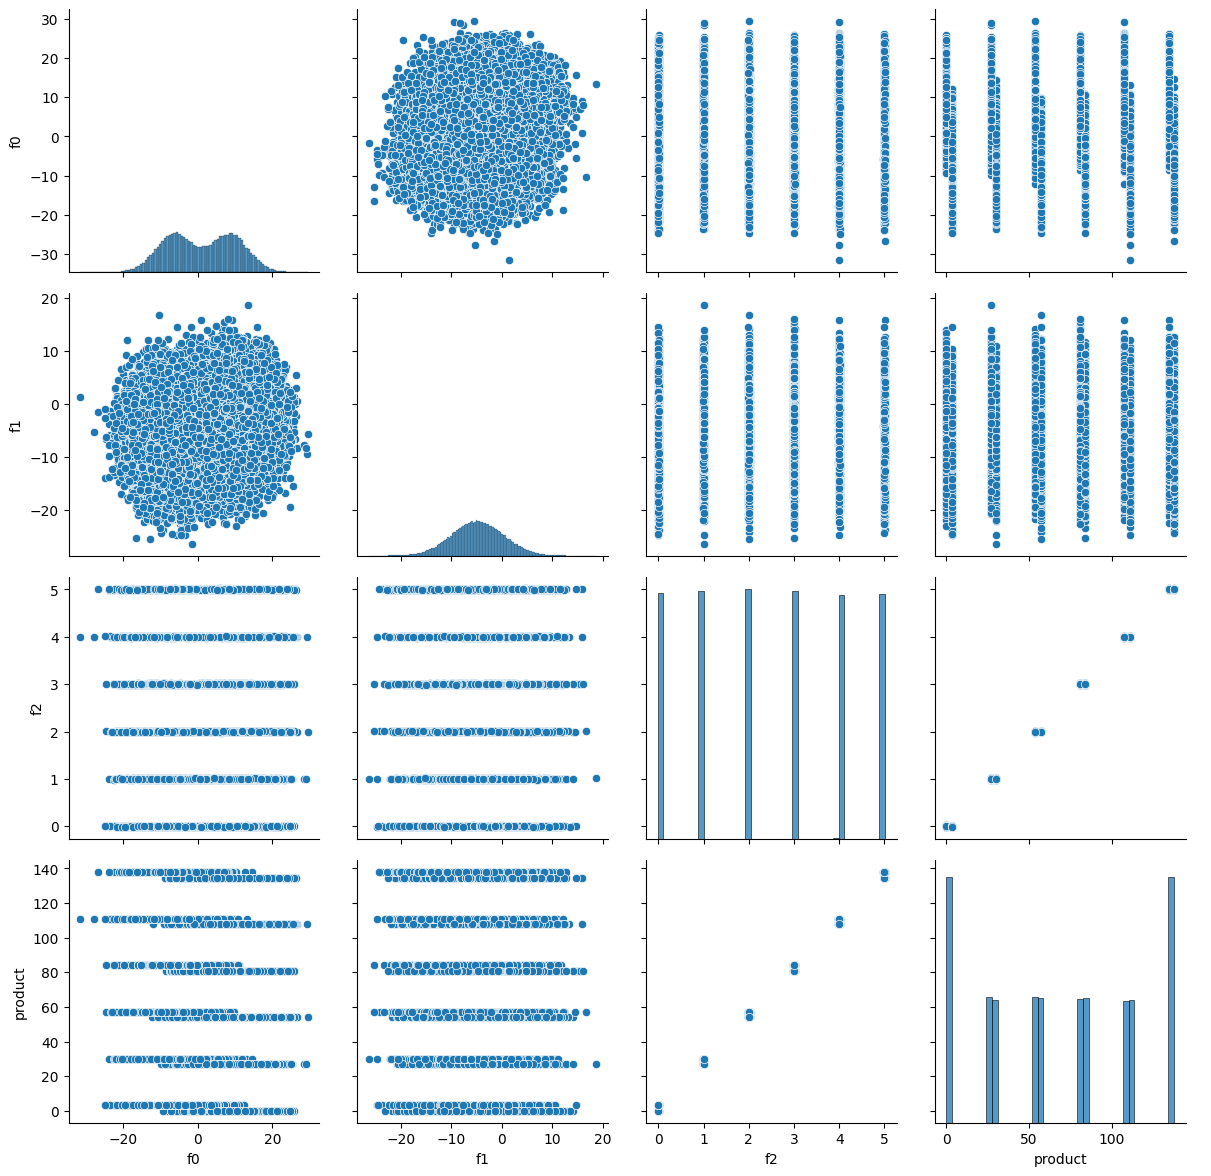

In [13]:
pair = sns.PairGrid(df_reg_2.drop('id', axis=1), height=3)
pair.map_diag(sns.histplot, hue=None)
pair.map_offdiag(sns.scatterplot)
pair.add_legend();

Text(0, 0.5, 'Number of values')

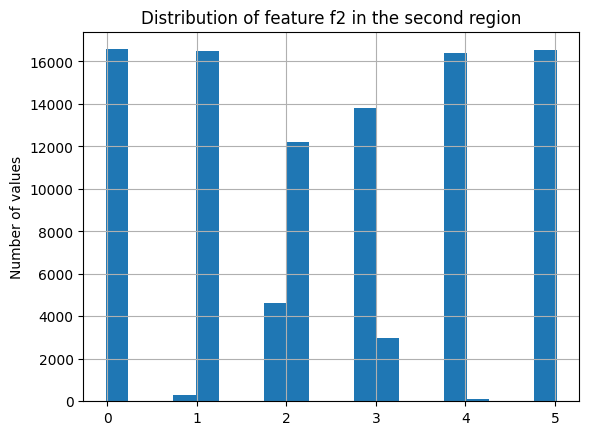

In [14]:
df_reg_2['f2'].hist(bins=20);
plt.title('Distribution of feature f2 in the second region')
plt.ylabel('Number of values')

In [15]:
df_reg_2['f2'].nunique()

100000

**In the second region, there is no strong correlation between input features, feature f0 has a bimodal distribution, feature f1 is normally distributed, and f2 looks like a noisy discrete feature, but for this task (and because linear regression for this region shows excellent quality), we will not change it to ordinal, and also f2 is completely collinear with the target, which is why the model has an R2 close to one and a standard error almost zero.**

**For the third region:**

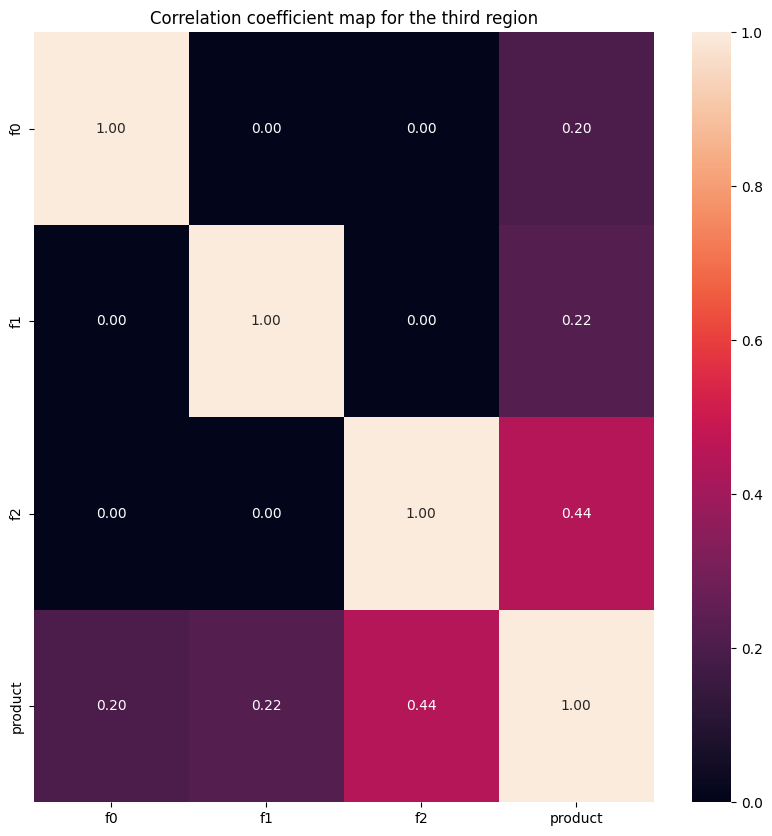

In [16]:
interval_cols = ['f0', 'f1', 'f2', 'product']
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Correlation coefficient map for the third region')
sns.heatmap(df_reg_3.drop('id', axis=1).phik_matrix(interval_cols=interval_cols),
            annot=True, 
            fmt='.2f',
            ax=ax) 
print()

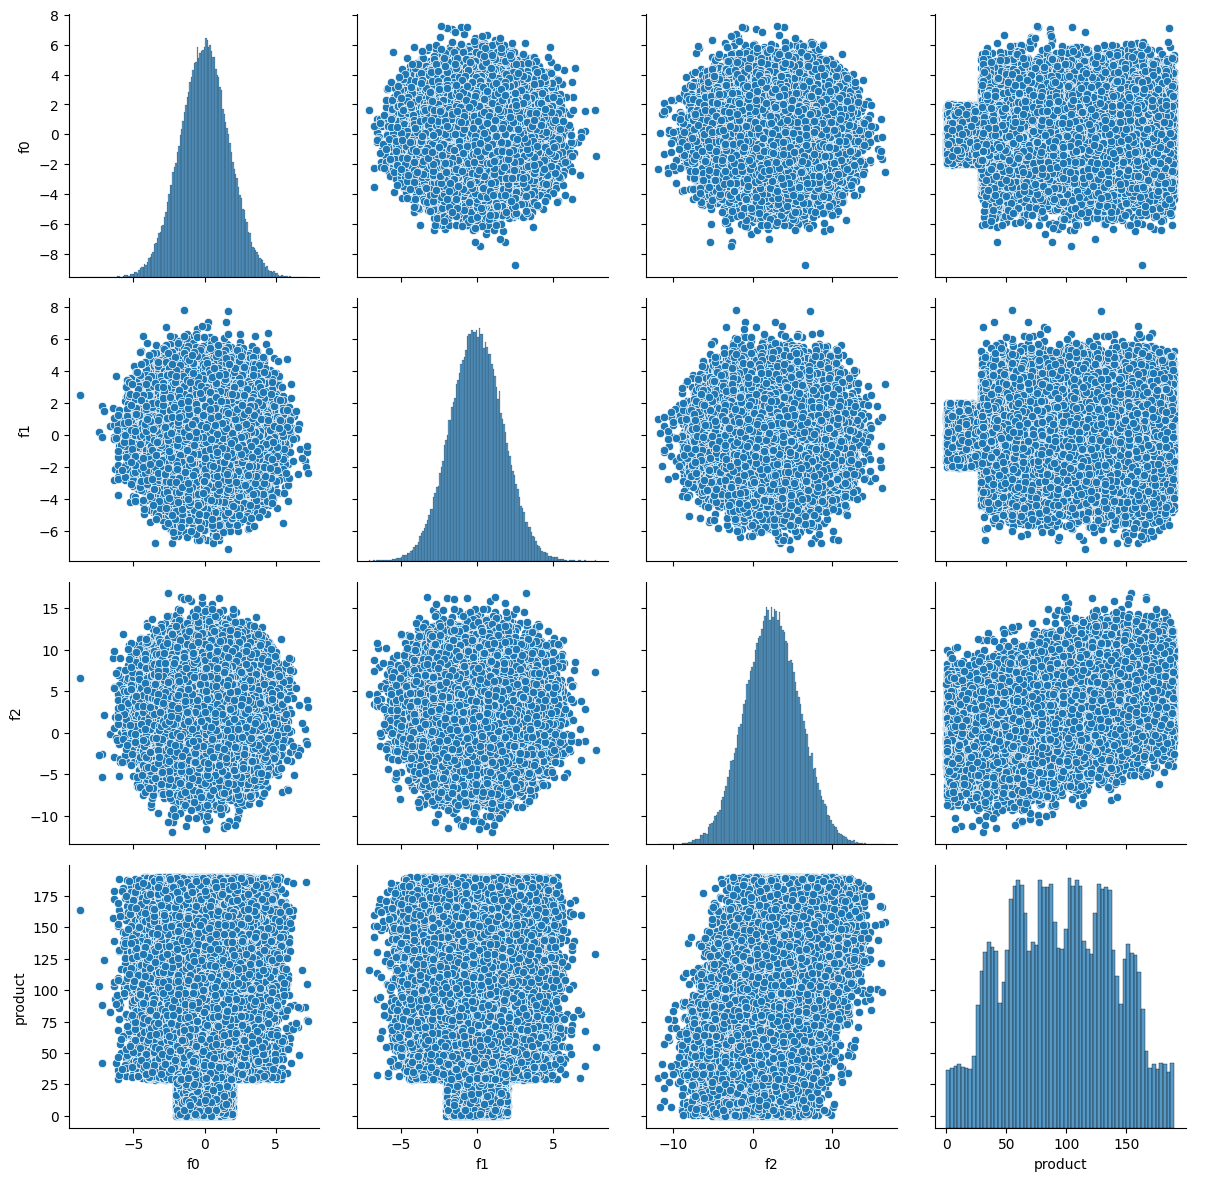

In [17]:
pair = sns.PairGrid(df_reg_3.drop('id', axis=1), height=3)
pair.map_diag(sns.histplot, hue=None)
pair.map_offdiag(sns.scatterplot)
pair.add_legend();

**In the third region, all features are independent and normally distributed, nothing abnormal.**

**Based on the correlation analysis, we remove feature f0 from the first region, as it strongly correlates with f1.**

## Model training and validation

**Let's split the data into training and validation sets, but first look at the range of feature values, scaling may be required**

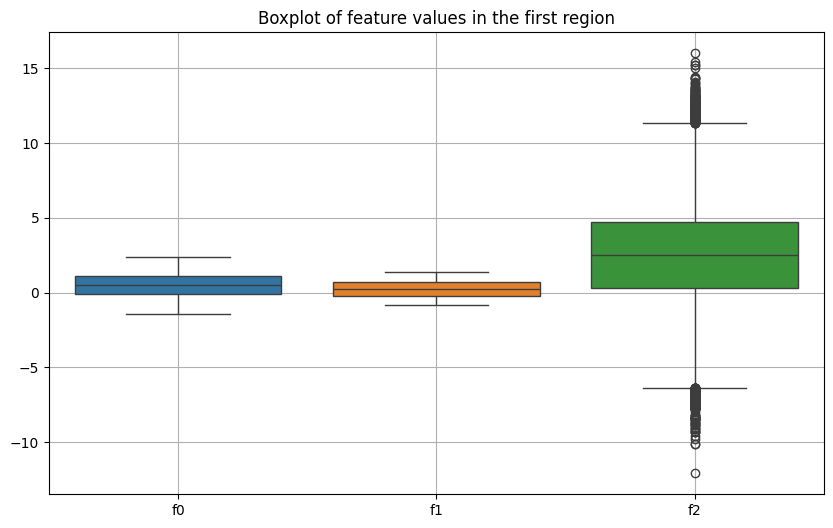

In [18]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_reg_1[['f0', 'f1', 'f2']]);
plt.title('Boxplot of feature values in the first region')
plt.grid()

**Features f0 and f1 are of the same order, f2 is an order of magnitude larger, so we will scale the data using StandardScaler(). Also, only 500 points are used for exploration in this task**

In [19]:
def preprocessing(df):
    X = df.drop('product', axis=1).set_index('id')
    y = df['product']

    X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train))
    X_val = pd.DataFrame(scaler.transform(X_val))
    
    return X_train, X_val, y_train, y_val

In [20]:
X_r1_train, X_r1_val, y_r1_train, y_r1_val = preprocessing(df_reg_1.drop('f0', axis=1))
X_r2_train, X_r2_val, y_r2_train, y_r2_val = preprocessing(df_reg_2)
X_r3_train, X_r3_val, y_r3_train, y_r3_val = preprocessing(df_reg_3)

In [21]:
X_r1_train.shape, X_r1_val.shape, y_r1_train.shape, y_r1_val.shape

((75000, 2), (25000, 2), (75000,), (25000,))

In [22]:
X_r2_train.shape, X_r2_val.shape, y_r2_train.shape, y_r2_val.shape

((75000, 3), (25000, 3), (75000,), (25000,))

In [23]:
X_r3_train.shape, X_r3_val.shape, y_r3_train.shape, y_r3_val.shape

((75000, 3), (25000, 3), (75000,), (25000,))

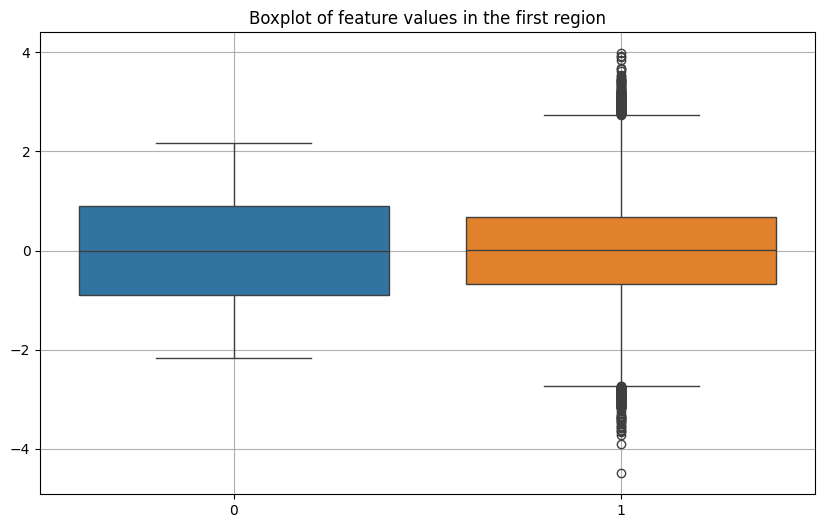

In [24]:
plt.figure(figsize=(10,6))
sns.boxplot(data=X_r1_train);
plt.title('Boxplot of feature values in the first region')
plt.grid()

**Splitting and scaling completed successfully, moving on to model training.**

In [25]:
model_lr1 = LinearRegression()
model_lr1.fit(X_r1_train, y_r1_train)
y_r1_pred = model_lr1.predict(X_r1_val)
RMSE = root_mean_squared_error(y_r1_val, y_r1_pred)
print('RMSE:', RMSE)
print('R2:', model_lr1.score(X_r1_val, y_r1_val))
print('Average oil reserves in the region:', y_r1_pred.mean())

RMSE: 37.89566516665846
R2: 0.2612459608559108
Average oil reserves in the region: 92.45257115948309


In [26]:
model_lr1.coef_

array([-8.65282944, 21.58595038])

In [27]:
model_lr2 = LinearRegression()
model_lr2.fit(X_r2_train, y_r2_train)
y_r2_pred = model_lr2.predict(X_r2_val)
RMSE = root_mean_squared_error(y_r2_val, y_r2_pred)
print('RMSE:', RMSE)
print('R2:', model_lr2.score(X_r2_val, y_r2_val))
print('Average oil reserves in the region:', y_r2_pred.mean())

RMSE: 0.8857076441957258
R2: 0.9996298568202542
Average oil reserves in the region: 68.51920639719152


In [28]:
model_lr2.coef_

array([-1.29781358, -0.11061652, 45.88567233])

In [29]:
model_lr3 = LinearRegression()
model_lr3.fit(X_r3_train, y_r3_train)
y_r3_pred = model_lr3.predict(X_r3_val)
RMSE = root_mean_squared_error(y_r3_val, y_r3_pred)
print('RMSE:', RMSE)
print('R2:', model_lr3.score(X_r3_val, y_r3_val))
print('Average oil reserves in the region:', y_r3_pred.mean())

RMSE: 40.10562308381635
R2: 0.19487075168240908
Average oil reserves in the region: 94.98365106986161


In [30]:
model_lr3.coef_

array([-8.81792449e-02, -1.31374518e-02,  2.00252451e+01])

**Based on the training results, we can draw the following conclusions:**
   * **The best quality metrics were obtained for the model for the second region, the input data shows excellent linear relationship with the target, R2 is close to one, and RMSE is 0.89 thousand barrels, but this region has the lowest average oil reserves, only 68.5 thousand barrels.**
   * **Models for the first and third regions have much higher RMSE (37.8 for the first and 40.1 for the third), and R2 <0.2, which is quite low, but these regions have a high average oil reserves: 92.5 thousand barrels for the first and 95 thousand barrels for the third region.**

## Preparing for profit calculation

In [31]:
INCOME_UNIT = 450_000
BUDGET = 10_000_000_000
WELL_NUM = 200

In [32]:
INC_PER_UNIT = BUDGET / WELL_NUM / INCOME_UNIT
print('To break even, at least', round(INC_PER_UNIT, 2), 'thousand barrels per well are needed.')

To break even, at least 111.11 thousand barrels per well are needed.


**The minimum oil reserves in a well for it to break even is 111.11 thousand barrels, so the first and third regions are more suitable based on average reserves.**

## Calculating profit and risks

**Let's write a function to calculate profit for selected wells, select the top 200 points according to the model, and calculate the income using the target feature.**

In [33]:
def revenue_billions(df):
    pred_top = df.sort_values(by='pred', ascending=False)[:200:]
    return (pred_top['target'].sum() * INCOME_UNIT - BUDGET) / 1_000_000_000

**Now, to calculate the profit distribution, apply Bootstrap with 1000 samples of 500 entries in the region and the best 200 wells for each region. Find the average profit, 95% confidence interval, and risk of loss.**

**First, calculate the metrics for the first region.**

In [34]:
r1_product = pd.DataFrame({'target': y_r1_val, 'pred': y_r1_pred})
print(r1_product.shape[0])
r1_product.head()

25000


,target,pred
39574,154.977625,95.202495
537,112.295792,133.690074
99246,127.443769,110.350112
39498,9.925158,64.954058
24797,52.618691,81.050517


In [35]:
state = np.random.RandomState(44)

values_r1 = []
for i in range(1000):
    subsample = r1_product.sample(n=500, replace=True, random_state=state)
    values_r1.append(revenue_billions(subsample))
values_r1 = pd.Series(values_r1)

lower = values_r1.quantile(0.025) 
lower

-0.13338298530998835

In [36]:
# REVIEWER CHECKS
subsample.shape

(500, 2)

**Calculate the probability of loss by computing the CDF of our empirical distribution at the tail 0 and below.**

In [37]:
st.percentileofscore(values_r1, 0)

8.6

**The risk of negative profit for the first region is 8.6%.**

In [38]:
values_r1[values_r1 <= 0]

1     -0.030262
11    -0.212187
29    -0.077029
41    -0.304623
44    -0.113263
         ...   
917   -0.097681
933   -0.016722
949   -0.227159
989   -0.076124
990   -0.115839
Length: 86, dtype: float64

**Now build a confidence interval using SciPy tools.**

In [39]:
print("Mean:", values_r1.mean().round(3), 'billion')

confidence_interval_r1 = st.t.interval(
confidence=0.95,
df=len(values_r1)-1,
loc=values_r1.mean(),
scale=values_r1.sem())

print("95% confidence interval for profit for the first region:", '(',
      round(confidence_interval_r1[0], 4), round(confidence_interval_r1[1], 4), ')')

Mean: 0.359 billion
95% confidence interval for profit for the first region: ( 0.3432 0.3753 )


**For the first region, the risk of loss is 8.6%, average profit is 359 million rubles with a 95% confidence interval from 343.2 million to 375.3 million.**

**Do the same for the second and third regions.**

In [40]:
r2_product = pd.DataFrame({'target': y_r2_val, 'pred': y_r2_pred})
print(r2_product.shape[0])
r2_product.head()

25000


,target,pred
39574,53.906522,53.927809
537,26.953261,26.111288
99246,3.179103,2.290219
39498,107.813044,107.831335
24797,3.179103,1.272958


In [41]:
state = np.random.RandomState(44)

values_r2 = []
for i in range(1000):
    subsample = r2_product.sample(n=500, replace=True, random_state=state)
    values_r2.append(revenue_billions(subsample))
values_r2 = pd.Series(values_r2)

lower = values_r2.quantile(0.025) 
lower

0.05245091442315206

In [42]:
st.percentileofscore(values_r2, 0)

1.7000000000000002

**Risk of negative profit is 1.7%.**

In [43]:
values_r2[values_r2 <= 0]

1     -0.020348
4     -0.094490
72    -0.005295
102   -0.005358
243   -0.049582
334   -0.021654
415   -0.104504
465   -0.086653
501   -0.106619
524   -0.058787
568   -0.088021
744   -0.081677
797   -0.185799
798   -0.070978
854   -0.171556
869   -0.003181
952   -0.027376
dtype: float64

In [44]:
print("Mean:", values_r2.mean().round(3), 'billion')

confidence_interval_r2 = st.t.interval(
confidence=0.95,
df=len(values_r2)-1,
loc=values_r2.mean(),
scale=values_r2.sem()+0.0001)

print("95% confidence interval for profit for the first region:", '(',
      round(confidence_interval_r2[0], 4), round(confidence_interval_r2[1], 4), ')')

Mean: 0.439 billion
95% confidence interval for profit for the first region: ( 0.4258 0.4516 )


**For the second region, the lower 2.5% quantile is also not negative, risks are less than 1.7%, average profit is 439 million rubles with a 95% confidence interval from 425.8 million to 451.6 million.**

In [45]:
r3_product = pd.DataFrame({'target': y_r3_val, 'pred': y_r3_pred})
print(r3_product.shape[0])
r3_product.head()

25000


,target,pred
39574,30.927826,96.177671
537,166.244516,87.006538
99246,93.182240,97.913842
39498,84.403121,56.762101
24797,104.505753,88.361431


In [46]:
state = np.random.RandomState(44)

values_r3 = []
for i in range(1000):
    subsample = r3_product.sample(n=500, replace=True, random_state=state)
    values_r3.append(revenue_billions(subsample))
values_r3 = pd.Series(values_r3)

lower = values_r3.quantile(0.025) 
lower

-0.22486170230293864

In [47]:
st.percentileofscore(values_r3, 0)

10.8

**The risk of negative profit in the third region is 10.8%.**

In [48]:
values_r3[values_r3 <= 0]

6     -0.245377
20    -0.019786
28    -0.328326
32    -0.070766
34    -0.101567
         ...   
977   -0.190375
982   -0.085285
988   -0.012288
989   -0.224669
992   -0.280783
Length: 108, dtype: float64

In [49]:
print("Mean:", values_r3.mean().round(3), 'billion')

confidence_interval_r3 = st.t.interval(
confidence=0.95,
df=len(values_r3)-1,
loc=values_r3.mean(),
scale=values_r3.sem())

print("95% confidence interval for profit for the first region:", '(',
      round(confidence_interval_r3[0], 4), round(confidence_interval_r3[1], 4), ')')

Mean: 0.31 billion
95% confidence interval for profit for the first region: ( 0.2939 0.3261 )


**For the third region, the risk of loss is 10.8%, average profit is 310 million rubles with a 95% confidence interval from 293.9 million to 326.1 million.**

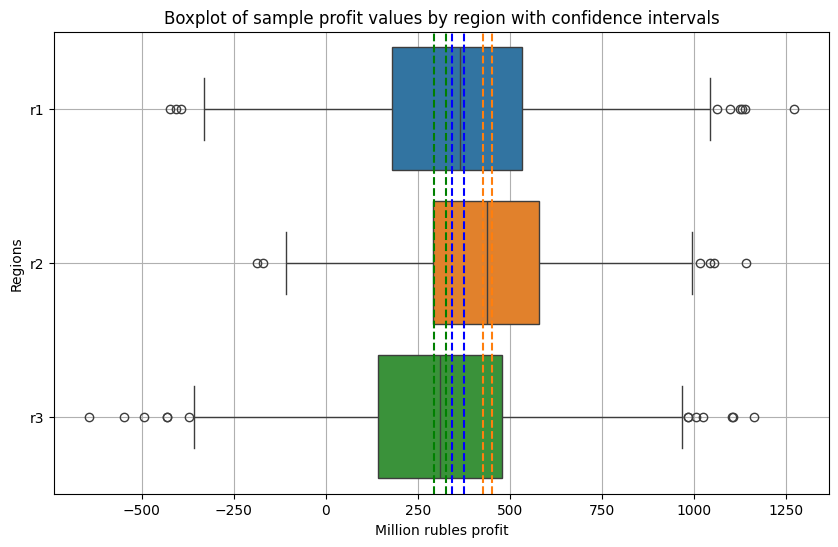

In [50]:
result_df = pd.DataFrame({
    'r1': values_r1 * 1_000,
    'r2': values_r2 * 1_000,
    'r3': values_r3 * 1_000
})

plt.figure(figsize=(10,6))
result_df['r2'] = result_df['r2'].astype("float64")
ax = sns.boxplot(data=result_df, orient='h')
plt.title('Boxplot of sample profit values by region with confidence intervals')
ax.axvline(x = 293.9, color = 'g', linestyle='--') #r3
ax.axvline(x = 326.1, color = 'g', linestyle='--') #r3
ax.axvline(x = 425.8, color = 'tab:orange', linestyle='--') #r2
ax.axvline(x = 451.6, color = 'tab:orange', linestyle='--') #r2
ax.axvline(x = 343.2, color = 'b', linestyle='--') #r1
ax.axvline(x = 375.3, color = 'b', linestyle='--') #r1
plt.xlabel('Million rubles profit')
plt.ylabel('Regions')
plt.grid()

**Analysis results and region selection: the most profitable region according to the analysis is the second region, and the risk of negative profit is only 1.7%, while the other regions did not meet the nominal <2.5%. The second region is better predicted by the model, but it has the lowest average oil per well. In conclusion, I can recommend the second region for potential oil production and well development.**